In [1]:
import json

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from music21 import stream, chord, note, midi

import pygame
from IPython.display import Audio

from sklearn.cluster import KMeans
from collections import Counter

pygame 2.6.0 (SDL 2.28.4, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Motif of sleeves on a women's shirt from Sofia Region

### Load the Colour to Notes mapping

In [2]:
# Load data from JSON file
with open('../color_data.json', 'r') as json_file:
    color_data = json.load(json_file)

# Convert RGB values from lists to tuples for immutability
target_colors = [tuple(data["RGB"]) for data in color_data.values()]

# Create color_to_note mapping with tuples as keys
color_to_note = {tuple(data["RGB"]): data["Note"] for data in color_data.values()}

## Image Crop 

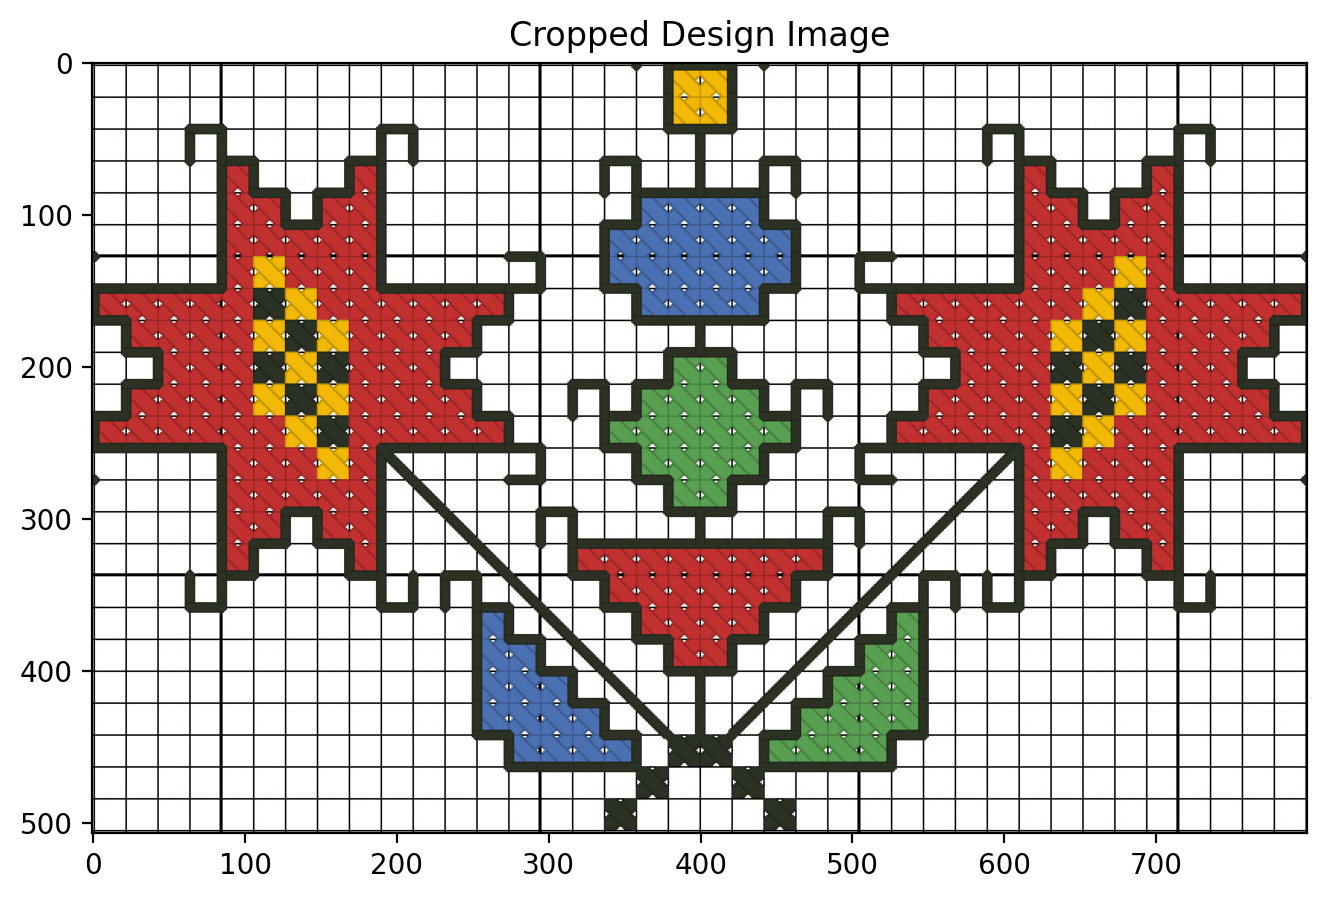

Cropped image saved to ../Images/Cropped_Design_image.png


In [3]:
design_image_path = '../Images/Design_2a.JPG'
design_image = cv2.imread(design_image_path)

# Define margins to remove
left_margin = 175
right_margin = 175
top_margin = 133
bottom_margin = 190

# Ensure the image has more width and height than the total margins
if design_image.shape[1] > left_margin + right_margin and design_image.shape[0] > top_margin + bottom_margin:
    # Perform cropping
    final_cropped_image = design_image[
        top_margin:-bottom_margin, left_margin:-right_margin
    ]
else:
    raise ValueError("The margins exceed the dimensions of the image, resulting in an invalid crop.")


# Optionally, save or display the result
cv2.imwrite('../Images/final_cropped_image.JPG', final_cropped_image)
# cv2.imshow('Cropped Image', final_cropped_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
"""
Convert the cropped image to RGB (OpenCV loads images in BGR format). 
The conversion from BGR to RGB is necessary to ensure that the color representation is accurate when 
interfacing with libraries or systems that expect images in RGB format. 
This conversion aligns with the expectations of these libraries and ensures that the colors are displayed or processed correctly.
""" 
cropped_image_rgb = cv2.cvtColor(final_cropped_image, cv2.COLOR_BGR2RGB)

# Display the cropped image
plt.figure(figsize=(10, 5))
plt.title('Cropped Design Image')
plt.imshow(cropped_image_rgb)
plt.show()

# Save the cropped image
output_path = '../Images/Cropped_Design_image.png'
cv2.imwrite(output_path, cv2.cvtColor(cropped_image_rgb, cv2.COLOR_RGB2BGR))
print(f"Cropped image saved to {output_path}")


## Remove the black color

The Black color in presented in all the columns. Later the same colors will be converted in same notes and the same note will be played durring the reproduction. I want to avoid this repetition. The white color will be removed from the final sound file. 

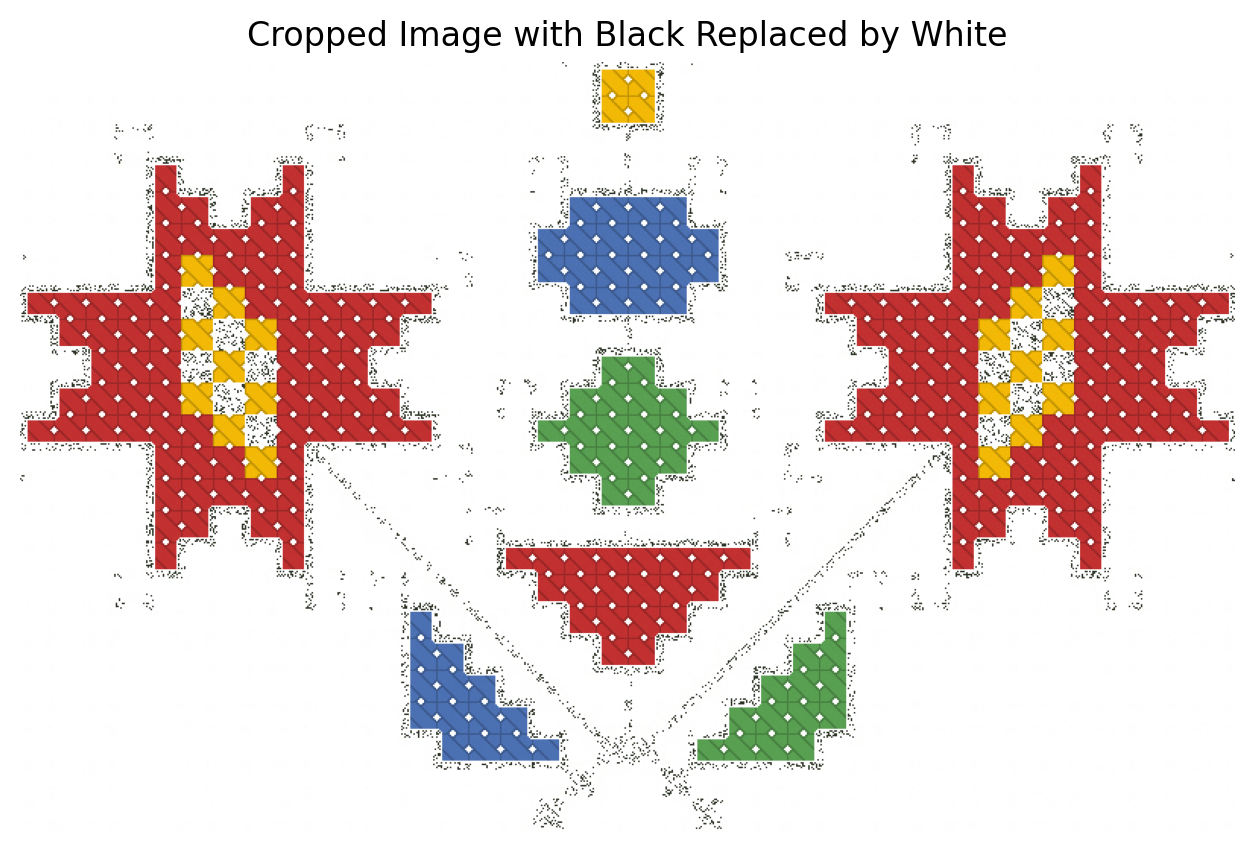

In [4]:
# Define the black color range in RGB
lower_black = np.array([0, 0, 0])
upper_black = np.array([50, 50, 50])

# Create a mask to identify the black areas in the image
mask = cv2.inRange(cropped_image_rgb, lower_black, upper_black)

# Convert the black areas to white
cropped_image_rgb[mask > 0] = [255, 255, 255]

# Convert the numpy array to PIL image
image_pil = Image.fromarray(cropped_image_rgb)

# Display the modified image
plt.figure(figsize=(10, 5))
plt.title('Cropped Image with Black Replaced by White')
plt.imshow(image_pil)
plt.axis('off')
plt.show()

# Save the modified image
output_path_replaced_black = '../Images/Cropped_Image_replaced_black.png'
image_pil.save(output_path_replaced_black)

Next steps are to dimish the number of the colors and the image size.

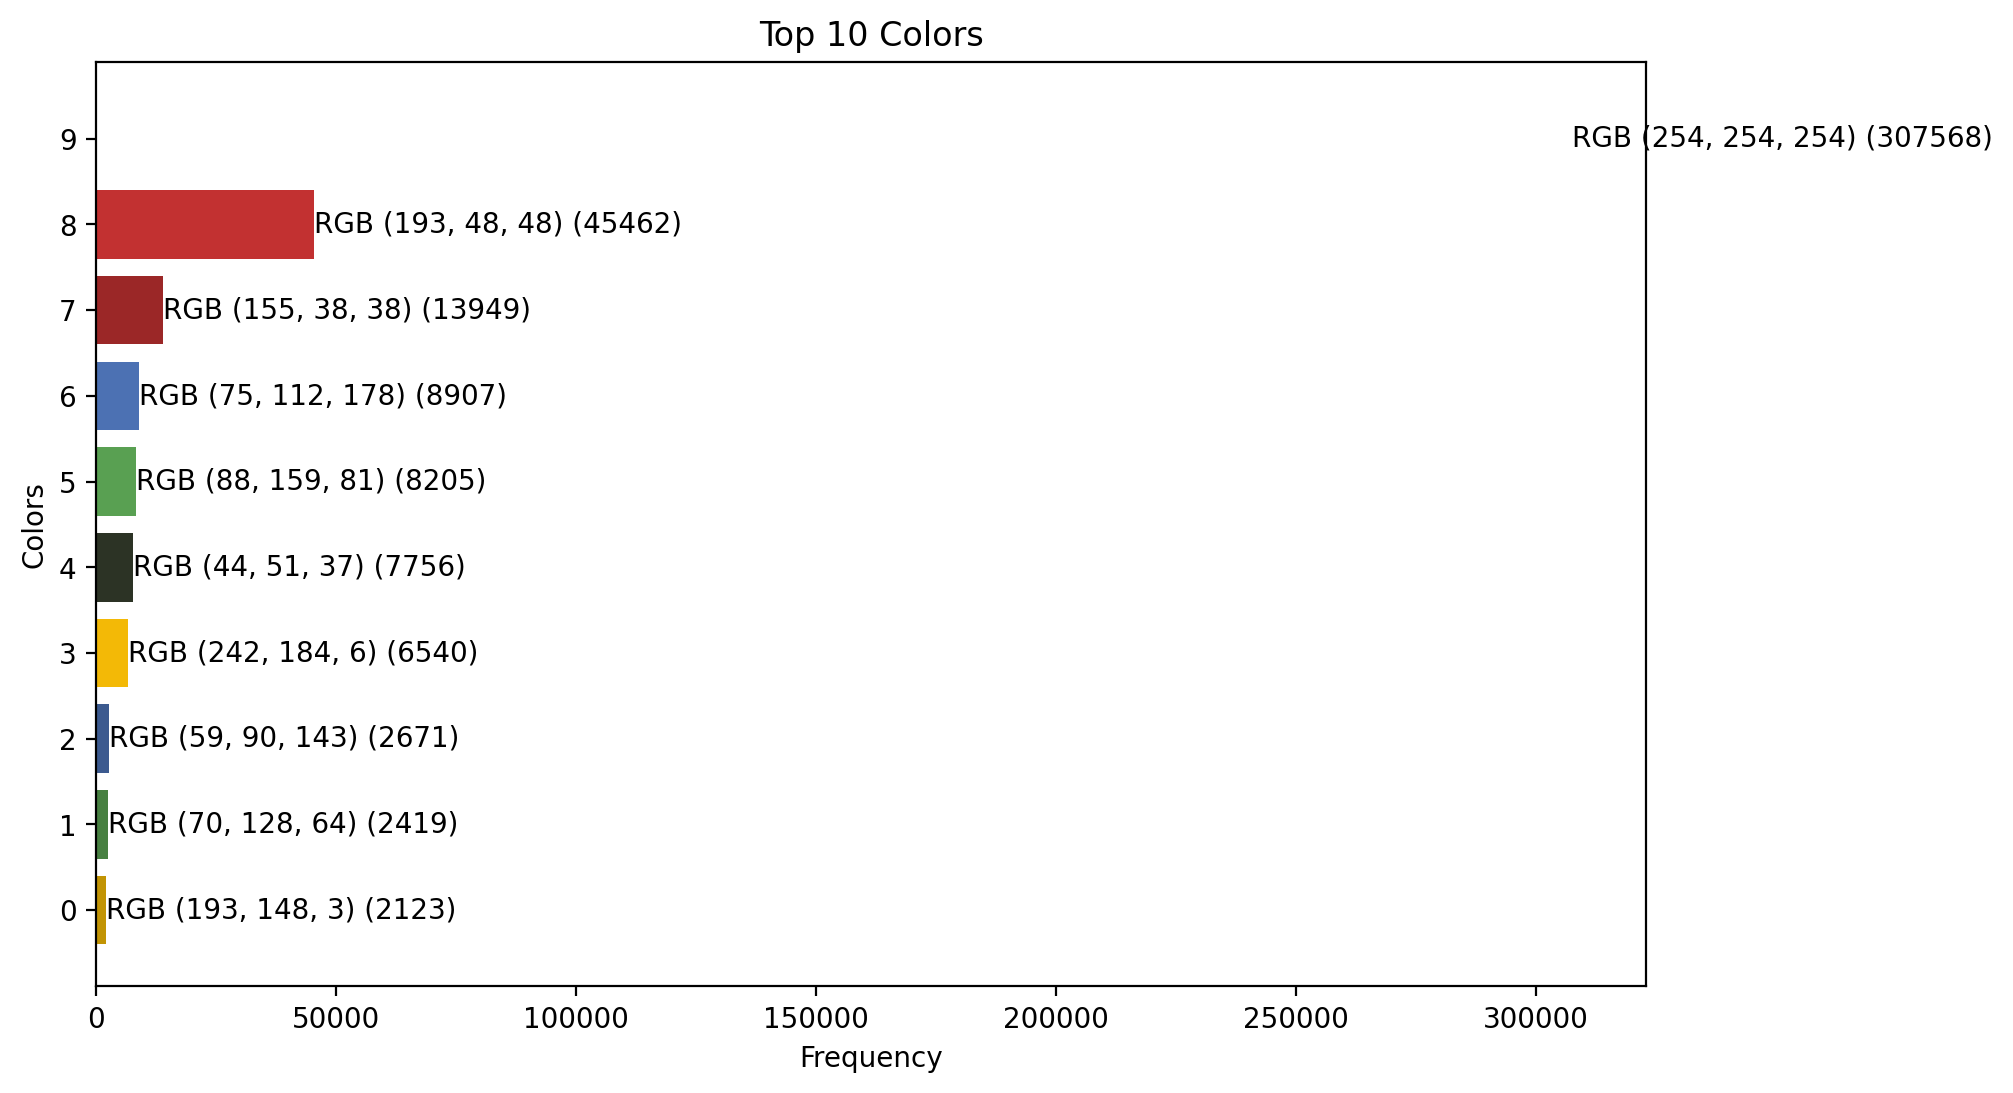

In [5]:
# Load the image
image_path = '../Images/Cropped_Image_replaced_black.PNG'
image = cv2.imread(image_path)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixels = image_rgb.reshape(-1, 3)

# Use KMeans to find the top 10 colors
num_colors = 10
kmeans = KMeans(n_clusters=num_colors, n_init=10)  # Set n_init explicitly
kmeans.fit(pixels)

# Get the colors and their frequencies
colors = kmeans.cluster_centers_
labels = kmeans.labels_
label_counts = Counter(labels)

# Sort the colors by frequency
sorted_colors = [colors[i] for i in label_counts.keys()]
sorted_counts = [label_counts[i] for i in label_counts.keys()]
sorted_indices = np.argsort(sorted_counts)[::-1]

top_colors = np.array(sorted_colors)[sorted_indices]
top_counts = np.array(sorted_counts)[sorted_indices]

# Display the top ten colors
def plot_colors(colors, counts):
    # Sort colors and counts by frequency in acending order
    sorted_indices = np.argsort(counts)[::1]
    sorted_colors = np.array(colors)[sorted_indices]
    sorted_counts = np.array(counts)[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Colors')
    
    # Create horizontal bar plot
    bars = plt.barh(range(len(sorted_colors)), sorted_counts, color=sorted_colors / 255)
    
    # Add color labels next to each bar
    for bar, color, count in zip(bars, sorted_colors, sorted_counts):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                 f'RGB {tuple(map(int, color))} ({count})', 
                 va='center', ha='left', fontsize=10)

    plt.xlabel('Frequency')
    plt.ylabel('Colors')
    plt.yticks(range(len(sorted_colors)))
    plt.show()

# Plot the top ten colors
plot_colors(top_colors[:num_colors], top_counts[:num_colors])


In [6]:
image_path = "../Images/Cropped_Image_replaced_black.png"
img = Image.open(image_path)

# Resize the image to 38x24
img_resized = img.resize((38, 24), Image.NEAREST)

# Function to find the nearest color from the target palette
def closest_color(pixel, colors):
    colors = np.array(colors)
    distances = np.sqrt(np.sum((colors - pixel) ** 2, axis=1))
    return colors[np.argmin(distances)]

# Get the image data as a numpy array
pixels = np.array(img_resized)

# Create an array to hold the new pixel data
new_pixels = np.zeros_like(pixels)

# Map each pixel to the nearest color in the palette
for i in range(pixels.shape[0]):
    for j in range(pixels.shape[1]):
        new_pixels[i, j] = closest_color(pixels[i, j], target_colors)

# Convert the new pixel array back to an image
new_img = Image.fromarray(new_pixels.astype('uint8'), 'RGB')

# Save the new image
new_image_path = "../Images/Pixelated_Image_Converted.png"
new_img.save(new_image_path)


In [7]:
# Load the design image
design_image_path = '../Images/Pixelated_Image_Converted.png'
design_image = cv2.imread(design_image_path)

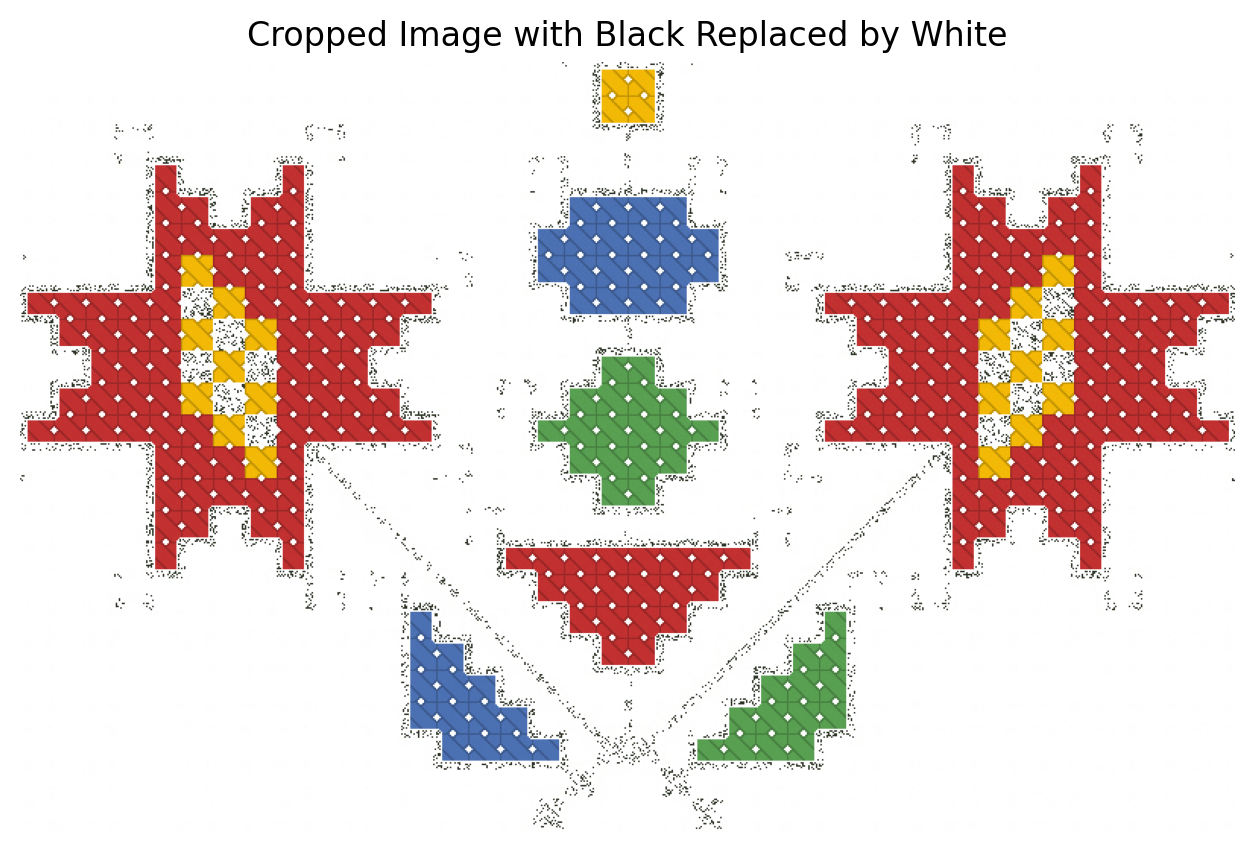

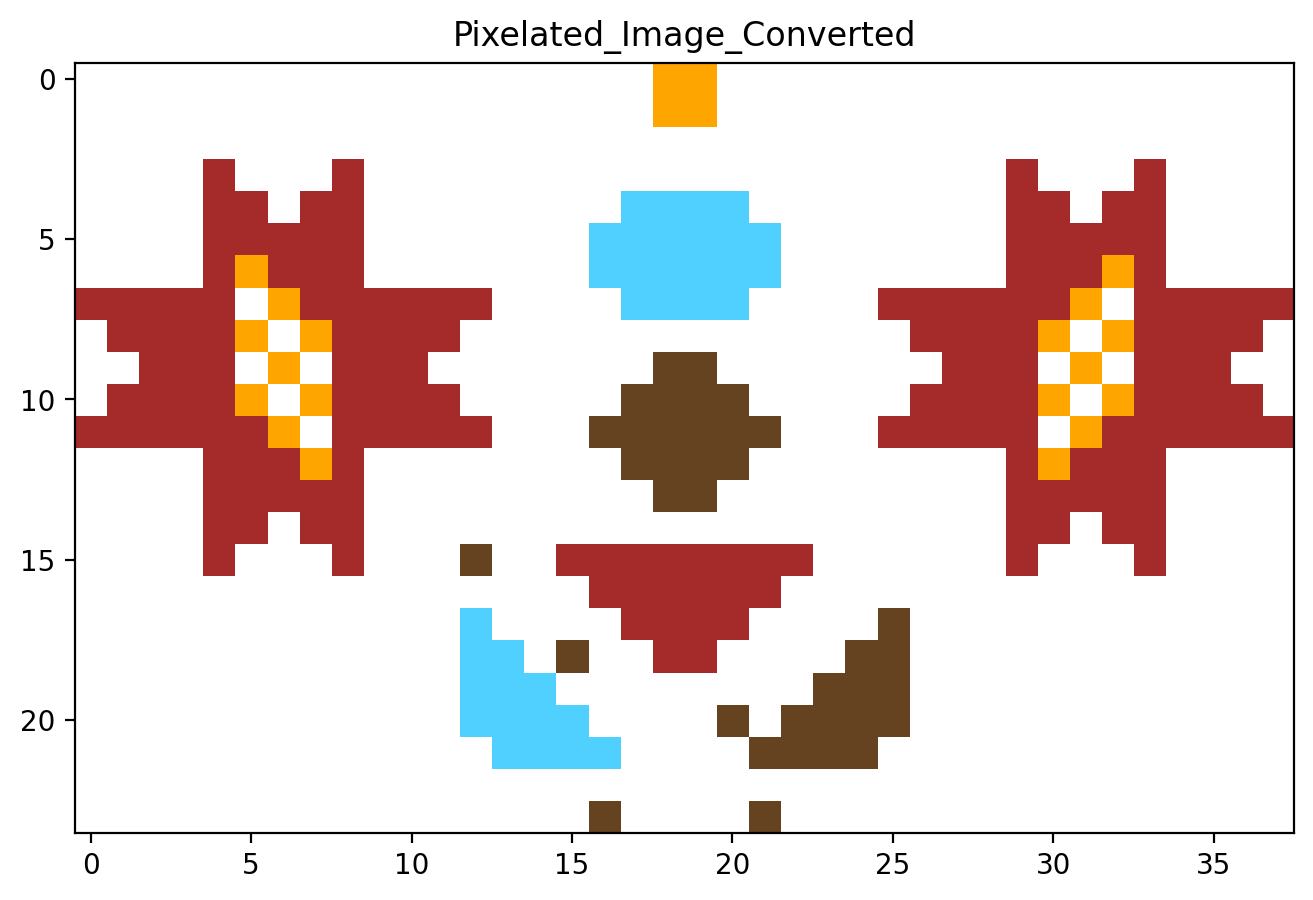

In [8]:
# Display the modified image
plt.figure(figsize=(10, 5))
plt.title('Cropped Image with Black Replaced by White')
plt.imshow(image_pil)
plt.axis('off')
plt.show()

# Convert BGR image to RGB
design_image_rgb = cv2.cvtColor(design_image, cv2.COLOR_BGR2RGB)

# Display the pixelated image in RGB format
plt.figure(figsize=(10, 5))
plt.title('Pixelated_Image_Converted')
plt.imshow(design_image_rgb)
plt.show()


It is time to convert the pixelated image into music chords. Each column will represent one chord (combination between one or more notes, or silence). The notes are related to the colours. To simplify the model, I will remove the duplicated colours in the columns.

In [9]:
design_image_array = np.array(design_image)

In [10]:
# Function to convert BGR to RGB
def bgr_to_rgb(bgr_color):
    return bgr_color[:, :, ::-1]

# Function to get unique colors for each column in RGB order
def unique_colors_by_column(array):
    height, width, _ = array.shape
    unique_colors = []
    
    # Convert the entire image array from BGR to RGB
    rgb_array = bgr_to_rgb(array)
    
    # Iterate over each column
    for col in range(width):
        # Extract the column data across all rows
        column_data = rgb_array[:, col, :]
        
        # Find unique colors in this column
        unique_colors_col = np.unique(column_data, axis=0)
        
        unique_colors.append(unique_colors_col)
    
    return unique_colors

# Get unique colors for each column
unique_colors = unique_colors_by_column(design_image_array)

# Create a list of unique colors for each column
unique_colors_list = [list(map(tuple, colors)) for colors in unique_colors]

# Output the list of unique colors
print(unique_colors_list)


[[(165, 42, 42), (255, 255, 255)], [(165, 42, 42), (255, 255, 255)], [(165, 42, 42), (255, 255, 255)], [(165, 42, 42), (255, 255, 255)], [(165, 42, 42), (255, 255, 255)], [(165, 42, 42), (255, 165, 0), (255, 255, 255)], [(165, 42, 42), (255, 165, 0), (255, 255, 255)], [(165, 42, 42), (255, 165, 0), (255, 255, 255)], [(165, 42, 42), (255, 255, 255)], [(165, 42, 42), (255, 255, 255)], [(165, 42, 42), (255, 255, 255)], [(165, 42, 42), (255, 255, 255)], [(80, 208, 255), (101, 67, 33), (165, 42, 42), (255, 255, 255)], [(80, 208, 255), (255, 255, 255)], [(80, 208, 255), (255, 255, 255)], [(80, 208, 255), (101, 67, 33), (165, 42, 42), (255, 255, 255)], [(80, 208, 255), (101, 67, 33), (165, 42, 42), (255, 255, 255)], [(80, 208, 255), (101, 67, 33), (165, 42, 42), (255, 255, 255)], [(80, 208, 255), (101, 67, 33), (165, 42, 42), (255, 165, 0), (255, 255, 255)], [(80, 208, 255), (101, 67, 33), (165, 42, 42), (255, 165, 0), (255, 255, 255)], [(80, 208, 255), (101, 67, 33), (165, 42, 42), (255, 255

In [11]:
#find unique colors:

# Flatten the list of lists
flat_list = [color for sublist in unique_colors_list for color in sublist]

# Get unique colors
unique_colors = set(flat_list)

# Convert to a sorted list for easier readability (optional)
unique_colors = sorted(unique_colors)

# Print unique colors
print("Unique colors:")
for color in unique_colors:
    print(color)


Unique colors:
(80, 208, 255)
(101, 67, 33)
(165, 42, 42)
(255, 165, 0)
(255, 255, 255)


In [12]:
# Map each color to its musical note
mapped_notes_list = []
for column in unique_colors_list:
    notes = [color_to_note.get(color, "Unknown") for color in column]
    mapped_notes_list.append(notes)

# Output the list of mapped notes
print(mapped_notes_list)


[['F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Bb3', 'Rest'], ['F4', 'Bb3', 'Rest'], ['F4', 'Bb3', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest'], ['D3', 'C4', 'F4', 'Rest'], ['D3', 'Rest'], ['D3', 'Rest'], ['D3', 'C4', 'F4', 'Rest'], ['D3', 'C4', 'F4', 'Rest'], ['D3', 'C4', 'F4', 'Rest'], ['D3', 'C4', 'F4', 'Bb3', 'Rest'], ['D3', 'C4', 'F4', 'Bb3', 'Rest'], ['D3', 'C4', 'F4', 'Rest'], ['D3', 'C4', 'F4', 'Rest'], ['C4', 'F4', 'Rest'], ['C4', 'Rest'], ['C4', 'Rest'], ['C4', 'F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Bb3', 'Rest'], ['F4', 'Bb3', 'Rest'], ['F4', 'Bb3', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest'], ['F4', 'Rest']]


In [13]:
# Create a stream for the MIDI data
midi_stream = stream.Stream()

# Convert each chord to music21 objects and add to the stream
for chord_notes in mapped_notes_list:
    chord_notes = [note for note in chord_notes if note != 'Rest']
    if chord_notes:
        midi_stream.append(chord.Chord(chord_notes))
    else:
        midi_stream.append(note.Rest())

# Set the duration of each note/chord (assuming quarter notes for simplicity)
for element in midi_stream:
    element.quarterLength = 1.0

# Create a MIDI file
mf = midi.translate.music21ObjectToMidiFile(midi_stream)

# Write the MIDI file to disk
mf.open('../Outputs/output2.mid', 'wb')
mf.write()
mf.close()


In [14]:
pygame.mixer.init()
pygame.mixer.music.load("../Outputs/output2.mid")
pygame.mixer.music.play()


### Bonus
After additional processing with https://www.soundtrap.com/

In [15]:
audio = Audio('../BonusTrack/Design Two.mp3')
audio